# Exercise 05 ANN for Multi-class Classificatoin - Instruction

## Pedagogy

This notebook serves as an instruction for implementing ANNs using Pytorch to develop multi-class classification models.

Please use this notebook as a reference and guide to complete the assignment.

### Pre-configure

Some of the new libraries used in this Jupyter Notebook:
- `os` for operating the file system
- `datetime` for obtaining and recording time

In [48]:
# import libraries
import os
import datetime
import warnings

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [49]:
# suppress all warnings
warnings.filterwarnings("ignore")

In [50]:
# get cpu, gpu or mps device for computation
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


## Part 1. ANN for Multi-class Classification

### Step 1. Build the data pipeline

We will use a toy dataset, the irir dataset, from `sklearn`. You can find more detials about this dataset at this [link](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn.datasets.load_iris).

As the iris dataset is a tabular dataset that consists of numerical feature variables and a categorical target variable. We can use `torch.utils.data.TensorDataset`, a custom class that inherits from the `torch.utils.data.Dataset` class.

In this step, we need to:
1. Use `sklearn.datasets.load_iris()` to load the dataset
2. Perform feature scaling for the numerical feature variables
3. Divide the dataset into the training, validation, and test set
4. Create `TensorDataset` instances to store the training, validation, and test set
    - <span style="color:red">For numerical features, set `dtype = torch.float32`</span>
    - <span style="color:red">For categorical labels, set `dtype = torch.long`</span>
5. Create `DataLoader` instances to wrap the training, validation, and test set as iterable objects

In [51]:
# load iris dataset
feature, label = datasets.load_iris(
    return_X_y = True,
    as_frame = False, # get data as numpy array
)

In [52]:
# feature scaling
scaler = StandardScaler()
scaled_feature = scaler.fit_transform(feature)

In [53]:
# Split the dataset into train, validation, and test sets
train_val_feature, test_feature, train_val_label, test_label = train_test_split(
    scaled_feature, label, test_size = 0.2, random_state = 0
)
train_feature, val_feature, train_label, val_label = train_test_split(
    train_val_feature, train_val_label, test_size = 0.25, random_state = 0
)

In [54]:
# create the train, validatoin, and test dataset
# specify the type of data stored in the tensors to avoid incompatiblity
train_ds = TensorDataset(
    torch.tensor(train_feature, dtype = torch.float32),
    torch.tensor(train_label, dtype = torch.long) #integer
)
val_ds = TensorDataset(
    torch.tensor(val_feature, dtype = torch.float32),
    torch.tensor(val_label, dtype = torch.long)
)
test_ds = TensorDataset(
    torch.tensor(test_feature, dtype = torch.float32),
    torch.tensor(test_label, dtype = torch.long)
)

For numerical featuers, we can set `dtype = torch.float32`.

For categorical labels, we need to set `dtype = torch.long`.

Find all available data types of `PyTorch` in the [documentation](https://pytorch.org/docs/stable/tensors.html).

In [55]:
# create the train and test data loaders
batch_size = 8 # usually set to 2 to the nth power
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = False)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = False)

### Step 2. Create the artificial neural network

To define a neural network in `PyTorch`, we create a class that inherits from `torch.nn.Module`.

We create a multi-layer ANN here for the multi-class problem:
- We add <span style="color:red">batch normalization</span> layers and <span style="color:red">dropout</span> layers using:
    - [`nn.BatchNorm1d()`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)
        - The `num_features` should be equal to the output dimension of the previous layer
        - Positioned before the activation function layer
    - [`nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)
        - Positioned after the activation function layer
- The number of output neurons is equal of the number of classes
- The activation functions of output neurons are linear
    - To get <span style="color:red">logits</span> as the outputs

In [56]:
# define a custom neural network class
class MultiClassificationNet(nn.Module):
    def __init__(self, n_features, n_labels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, 16),
            #nn.BatchNorm1d(16), # batch normalization
            #nn.ReLU(), #Linear activation function
            #nn.Dropout(p = 0.5), # dropout with 50% probability
            nn.Linear(16, 8),
            #nn.BatchNorm1d(8), # batch normalization
            #nn.ReLU(),
            #nn.Dropout(p = 0.5), # dropout with 50% probability
            nn.Linear(8, n_labels)
        )
    def forward(self, X):
        return self.net(X)

In [57]:
# create the neural network
model = MultiClassificationNet(
    n_features = feature.shape[1],
    n_labels = len(np.unique(label))
)
model.to(device)

MultiClassificationNet(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=3, bias=True)
  )
)

In [58]:
# print network structure and learning parameters
print(f"Model structure:\n{model}\n")
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()}")

Model structure:
MultiClassificationNet(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=3, bias=True)
  )
)

Layer: net.0.weight | Size: torch.Size([16, 4])
Layer: net.0.bias | Size: torch.Size([16])
Layer: net.1.weight | Size: torch.Size([8, 16])
Layer: net.1.bias | Size: torch.Size([8])
Layer: net.2.weight | Size: torch.Size([3, 8])
Layer: net.2.bias | Size: torch.Size([3])


We can see, apart from the linear layers, the batch normalization layers also have learning parameters.
- These learning parameters are also optimized during the training process
- The network may learn to deactivate the batch normalization, then:
    -  the learned weight is equal to the original standard deviation of the corresponding feature before batch normalization
    -  the learned bias is equal to the original mean of the corresponding feature before batch normalization
    -  This means we can let the ANN learn whether to use batch normalization or not by itself

### Step 3. Train the network

We define a `train()` function to perform the training process, which takes the following parameters:
- A data loader of the training set
- A data loader of the validation set
- A loss function (<span style="color:red">use `nn.CrossEntropyLoss()` for multi-class classification</span>)
- An optimizer (with L2 Regularization, learning rate decay, and early stopping)
- The maximum number of epoches to train
- The prefix of file name for automatically saving models during the training process

There is one thing different for multi-class classification.
- <span style="color:red">The outputs of the ANN is logits</span>
    - not probabilities
    - not predictions
- <span style="color:red">The `nn.CrossEntropyLoss()` takes logits as inputs to compute the loss</span>
    - `nn.CrossEntropyLoss()` applies softmax internally

In [59]:
# define the training function
def train(
    train_dl,
    val_dl,
    model,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler,
    saved_path_prefix
):
    # initialization
    min_val_loss = np.inf # initialize the val loss as an infinite positive value
    patience_counter = 0 # set the initial patience counter to zero
    histories = {
        'train_batch': [],
        'train_epoch': [],
        'val_batch': [],
        'val_epoch': []
    } # aggregate loss histories into a dictionary
    saved_path = '' # create saved_path
    
    # start training
    for epoch in range(epochs): # iterate pre-defined number of epoches
        # train set
        train_epoch_loss = 0.0
        model.train() # set the model in training mode
        for (X, y) in train_dl:
            X, y = X.to(device), y.to(device)
            logits = model(X) # forward propagation
            train_batch_loss = loss_fn(logits, y)
            train_batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            histories['train_batch'].append(train_batch_loss.item())
            train_epoch_loss += train_batch_loss.item()
        train_epoch_loss /= len(train_dl)
        histories['train_epoch'].append(train_epoch_loss)
        
        # validation set
        val_epoch_loss = 0.0
        model.eval() # set the model in evaluation mode
        with torch.no_grad():
            for (X, y) in val_dl:
                X, y = X.to(device), y.to(device)
                logits = model(X) # forward propagation
                val_batch_loss = loss_fn(logits, y)
                histories['val_batch'].append(val_batch_loss.item())
                val_epoch_loss += val_batch_loss.item()
            val_epoch_loss /= len(val_dl)
            histories['val_epoch'].append(val_epoch_loss)

        # print log
        print(f"Epoch {epoch + 1}: train loss = {train_epoch_loss:>5f}, val loss = {val_epoch_loss:>5f}")
        
        # learning rate decay
        current_lr = optimizer.param_groups[0]['lr']
        lr_scheduler.step(val_epoch_loss)
        new_lr = optimizer.param_groups[0]['lr']
        if current_lr != new_lr:
            print(f'Learning rate reduced after epoch {epoch+1}\n')
            
        # early stopping
        if val_epoch_loss < min_val_loss:
            min_val_loss = val_epoch_loss # update the new min val loss
            patience_counter = 0 # reset patience counter to zero
            # save the current model as a new min_val_loss is achieved
            if os.path.exists(saved_path):
                os.remove(saved_path)
            time_str = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            saved_path = saved_path_prefix + f'_epoch_{epoch+1}_val_loss_{val_epoch_loss:>4f}_{time_str}.pth'
            torch.save(model.state_dict(), saved_path)
            print(f'Model saved after epoch {epoch+1}\n')
        else:
            patience_counter += 1 # increase patience counter by 1
        if patience_counter >= early_stopping_patience:
            print('Early stopping!')
            break
    return histories, saved_path

In [41]:
# define the training hyper-parameters
loss_fn = nn.CrossEntropyLoss() # use cross entropy loss for multi-class
learning_rate = 1e-1 # initial learning rate
weight_decay = 1e-5 # lambda for L2 regularization
optimizer = torch.optim.SGD(
    model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay # add L2 regularization
)
epochs = 1000 # maximum number of epochs to train
early_stopping_patience = 20
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1, # each step multiply the learning rate with 0.1
    patience = 5
)
saved_path_prefix = 'multi_class_net'

In [60]:
# train the neural network
histories, saved_path = train(
    train_dl,
    val_dl,
    model,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler,
    saved_path_prefix
)

Epoch 1: train loss = 1.100720, val loss = 1.117434
Model saved after epoch 1

Epoch 2: train loss = 1.129774, val loss = 1.117434
Epoch 3: train loss = 1.143920, val loss = 1.117434
Epoch 4: train loss = 1.142878, val loss = 1.117434
Learning rate reduced after epoch 4

Epoch 5: train loss = 1.129331, val loss = 1.117434
Epoch 6: train loss = 1.143065, val loss = 1.117434
Epoch 7: train loss = 1.100001, val loss = 1.117434
Epoch 8: train loss = 1.129123, val loss = 1.117434
Epoch 9: train loss = 1.128861, val loss = 1.117434
Epoch 10: train loss = 1.098969, val loss = 1.117434
Learning rate reduced after epoch 10

Epoch 11: train loss = 1.113680, val loss = 1.117434
Epoch 12: train loss = 1.128449, val loss = 1.117434
Epoch 13: train loss = 1.143393, val loss = 1.117434
Epoch 14: train loss = 1.161132, val loss = 1.117434
Epoch 15: train loss = 1.126837, val loss = 1.117434
Epoch 16: train loss = 1.146604, val loss = 1.117434
Learning rate reduced after epoch 16

Epoch 17: train loss 

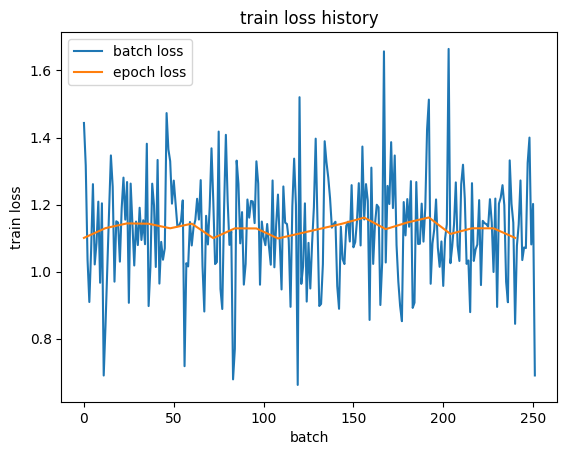

In [61]:
# plot the train loss history
plt.figure()
batch = np.arange(len(histories['train_batch']))
epoch = np.arange(len(histories['train_epoch']))
batches_per_epoch = (int(len(train_ds) / batch_size + 1))
plt.plot(batch, histories['train_batch'], '-', label = 'batch loss')
plt.plot(epoch * batches_per_epoch, histories['train_epoch'], '-', label = 'epoch loss')
plt.title('train loss history')
plt.xlabel('batch')
plt.ylabel('train loss')
plt.legend()
plt.show()

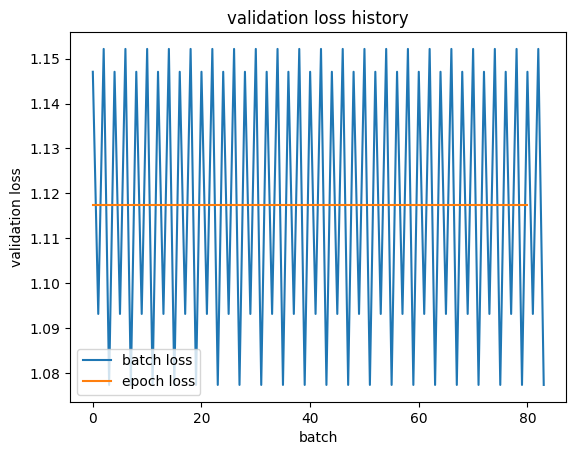

In [62]:
# plot the val loss history
plt.figure()
batch = np.arange(len(histories['val_batch']))
epoch = np.arange(len(histories['val_epoch']))
batches_per_epoch = (int(len(val_ds) / batch_size + 1))
plt.plot(batch, histories['val_batch'], '-', label = 'batch loss')
plt.plot(epoch * batches_per_epoch, histories['val_epoch'], '-', label = 'epoch loss')
plt.title('validation loss history')
plt.xlabel('batch')
plt.ylabel('validation loss')
plt.legend()
plt.show()

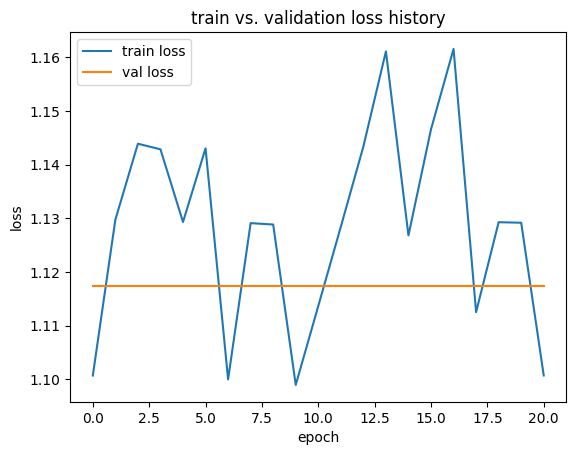

In [63]:
# plot the train vs. val loss history
plt.figure()
plt.plot(np.arange(len(histories['train_epoch'])), histories['train_epoch'], '-', label = 'train loss')
plt.plot(np.arange(len(histories['val_epoch'])), histories['val_epoch'], '-', label = 'val loss')
plt.title('train vs. validation loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### Step 4. Reload the best model

<span style="color:red">The final model after training may not be the best one saved during the traing process.</span>

<span style="color:red">To use the best model, we need to reload it from the saved file.</span>

In [64]:
# load model
model = MultiClassificationNet(
    n_features = feature.shape[1],
    n_labels = len(np.unique(label))
)
model.load_state_dict(torch.load(saved_path))
model.to(device)

MultiClassificationNet(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=3, bias=True)
  )
)

### Step 5. Make predictions and evaluation

Make predictions on the test set and evaluation the performance of the network.

As the outputs of the ANN are logits, which can be used to calculate the loss using `nn.CrossEntropyLoss()`, but <span style="color:red">we can't use these logits directly as the predicted probabilities or predicted classes</span>. We need to:
- <span style="color:red">Convert the logits to probabilities using `torch.softmax()`</span>
- <span style="color:red">Convert the probabilities to predicted classes using `torch.max()`</span>

In [65]:
# define a function to make predictions on test dataset and evaluate the performance
def test(dataloader, model, loss_fn):
    batch_logits_list = [] # for recording batch logits
    batch_prob_list = [] # for recording batch probabilities
    batch_pred_list = [] # for recording batch predictions
    model.eval() # set the model in evaluation mode
    with torch.no_grad(): # disable automatic gradient computing
        loss = 0.0
        for (X, y) in dataloader:
            X, y = X.to(device), y.to(device)
            batch_logits = model(X) # forward propagation
            batch_loss = loss_fn(batch_logits, y)
            loss += batch_loss.item()
            batch_prob = torch.softmax(batch_logits, dim = -1) # convert logtis to probabilities
            _, batch_pred = torch.max(batch_logits, 1) # conver probabilities to predictions
            batch_logits_list.append(batch_logits.cpu().numpy()) # record logits on current batch
            batch_prob_list.append(batch_prob.cpu().numpy()) # record probabilities on current batch
            batch_pred_list.append(batch_pred.cpu().numpy()) # record predictions on current batch
        loss /= len(dataloader) # compute test loss
        logits = np.concatenate(batch_logits_list) # reform the logits
        prob = np.concatenate(batch_prob_list) # reform the probabilities
        pred = np.concatenate(batch_pred_list) # reform the predictions
        print(f"test loss = {loss}") # print log
    return logits, prob, pred, loss

In [66]:
# make prediction on test set and evaluate the performance
test_logits, test_prob, test_pred, test_loss = test(test_dl, model, loss_fn)
classes = ['Iris-Setosa', 'Iris-Versicolour', 'Iris-Virginica']
print(classification_report(test_label, test_pred, target_names = classes))

test loss = 1.2377294898033142
                  precision    recall  f1-score   support

     Iris-Setosa       0.00      0.00      0.00        11
Iris-Versicolour       0.00      0.00      0.00        13
  Iris-Virginica       0.22      1.00      0.36         6

        accuracy                           0.20        30
       macro avg       0.07      0.33      0.12        30
    weighted avg       0.04      0.20      0.07        30



## Part 2. Obtain an over-fitted model

We have applied various techniques to prevent the model from overfitting:
- L2 regularization / weight decay
- early stopping
- learning rate decay
- Dropout
- Batch normalization

<span style="color:red">Now let's try to remove or deactivate them and increase the capacity of the ANN to see if you can get an over-fitted model.</span>

In practice, we always start with an over-fitted model to ensure it has enough capacity.

Then we adopt different techniques to try to prevent overfitting.